# Курсовой проект
***Выполнил***

***группа:*** М8О-114СВ-24

***студент:*** Зайцев Кирилл Владимирович 

In [1]:
import lime
import shap
import optuna
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

/home/kirill/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

In [2]:
data = pd.read_csv('creditcard_2023.csv')

In [3]:
data.head()

id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28    Amount  Class  
0 -0.434824 -0.081230 -0.151045  17982.10      0  
1  0.296503 -0.248052 -0.064512   6531.37      0  
2 -0.312895 -0.300258 -0.244718   2513.54      0  
3 -0.515950 -0.165316  0.048424   5384.44      0  
4  1.071126  0.023712  0.419117  14278.97      0  

[5 rows x 31 columns]

In [4]:
X = data.drop(columns=['id', 'Class'])
y = data['Class']

<Axes: >

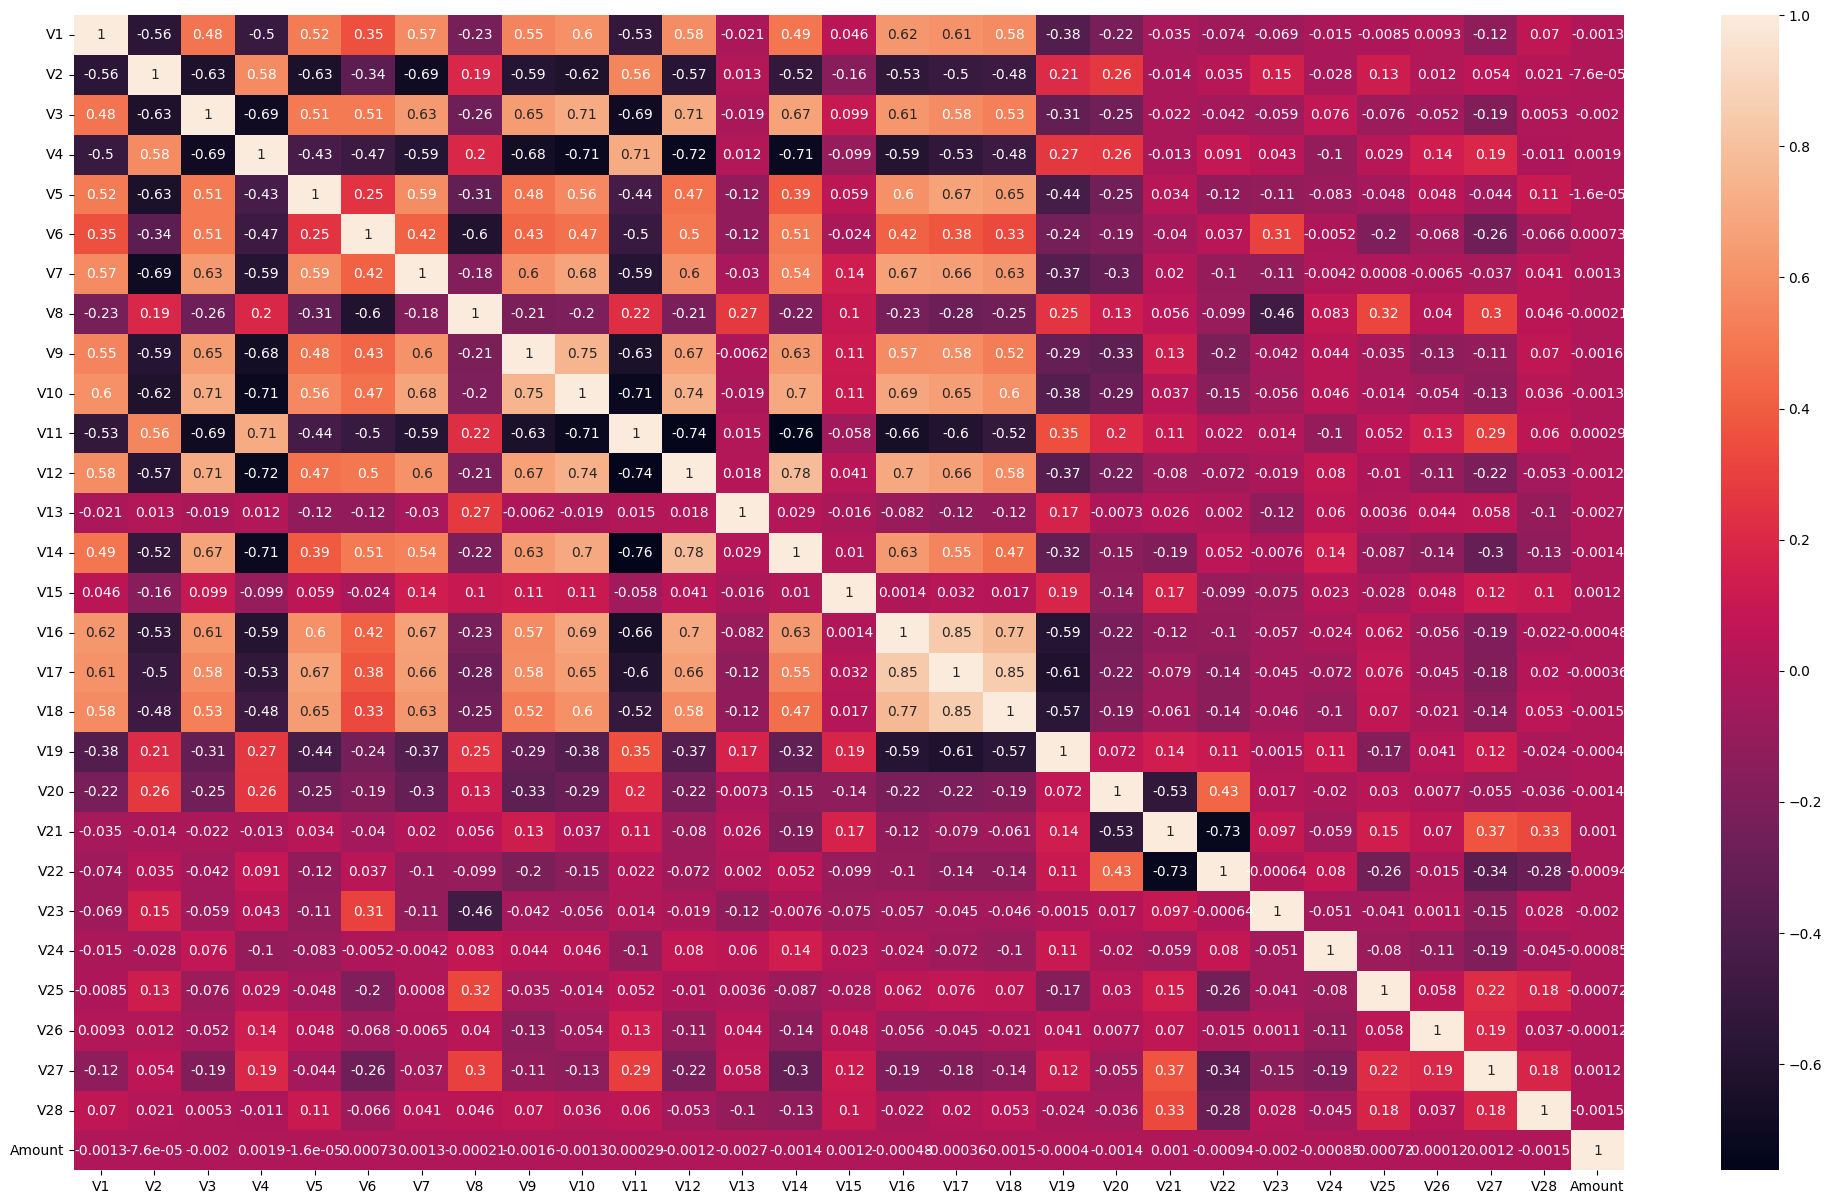

In [6]:
plt.figure(figsize=(25, 15))
sns.heatmap(X.corr(), annot=True)

In [7]:
palette = ["#00203FFF", "#ADEFD1FF"]

def single_plot_distribution(column_name, dataframe):
    value_counts = dataframe[column_name].value_counts()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]}) 
    pie_colors = palette[0:3]
    ax1.pie(value_counts, autopct='%0.001f%%', startangle=90, pctdistance=0.85, colors=pie_colors, labels=None)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax1.add_artist(centre_circle)
    ax1.set_title(f'Distribution of {column_name}', fontsize=16)
    bar_colors = palette[0:3]
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=bar_colors,) 
    ax2.set_title(f'Count of {column_name}', fontsize=16)
    ax2.set_xlabel(column_name, fontsize=14)
    ax2.set_ylabel('Count', fontsize=14)
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

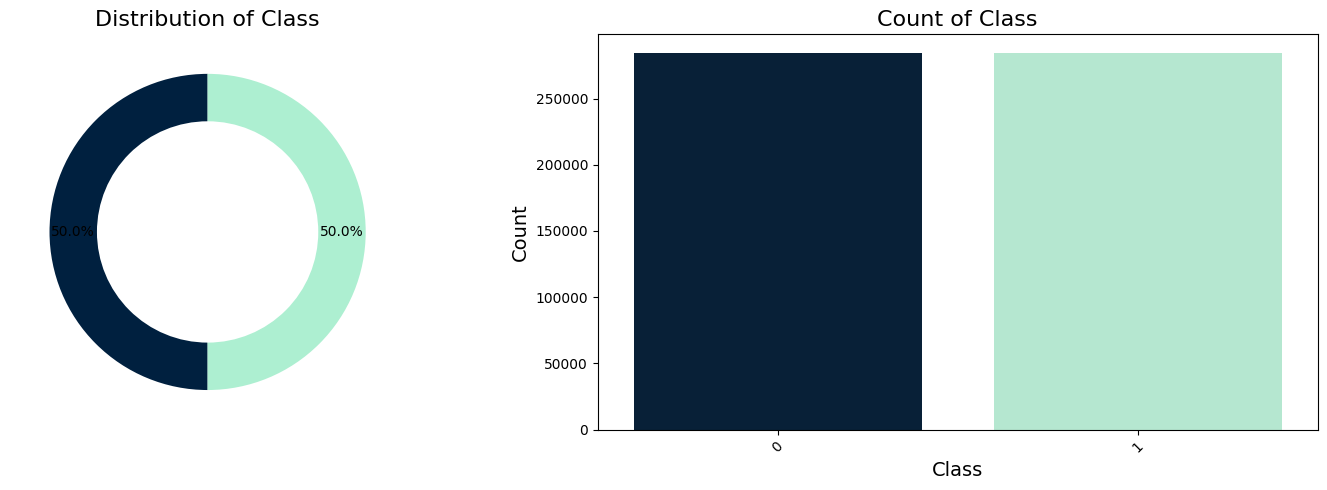

In [8]:
single_plot_distribution('Class', data)

In [9]:
def plot_numerical_distribution_with_hue(data, num_cols, hue_col='Gender', figsize=(25, 25), dpi=100):
    rows = (len(num_cols) + 1) // 2 
    fig, ax = plt.subplots(rows, 2, figsize=figsize, dpi=dpi)
    ax = ax.flatten() 
    for i, column in enumerate(num_cols):  
        sns.histplot(data=data, x=column, hue=hue_col, ax=ax[i], kde=True, palette=palette)
        ax[i].set_title(f'{column} Distribution', size=14)
        ax[i].set_xlabel(None)
        ax[i].set_ylabel(None)
        skewness = skew(data[column].dropna())
        skew_label = f'Skewness: {skewness:.2f}'
        ax[i].annotate(skew_label, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, color='red')
    for j in range(len(num_cols), len(ax)):
        fig.delaxes(ax[j])
    plt.tight_layout()
    plt.show()



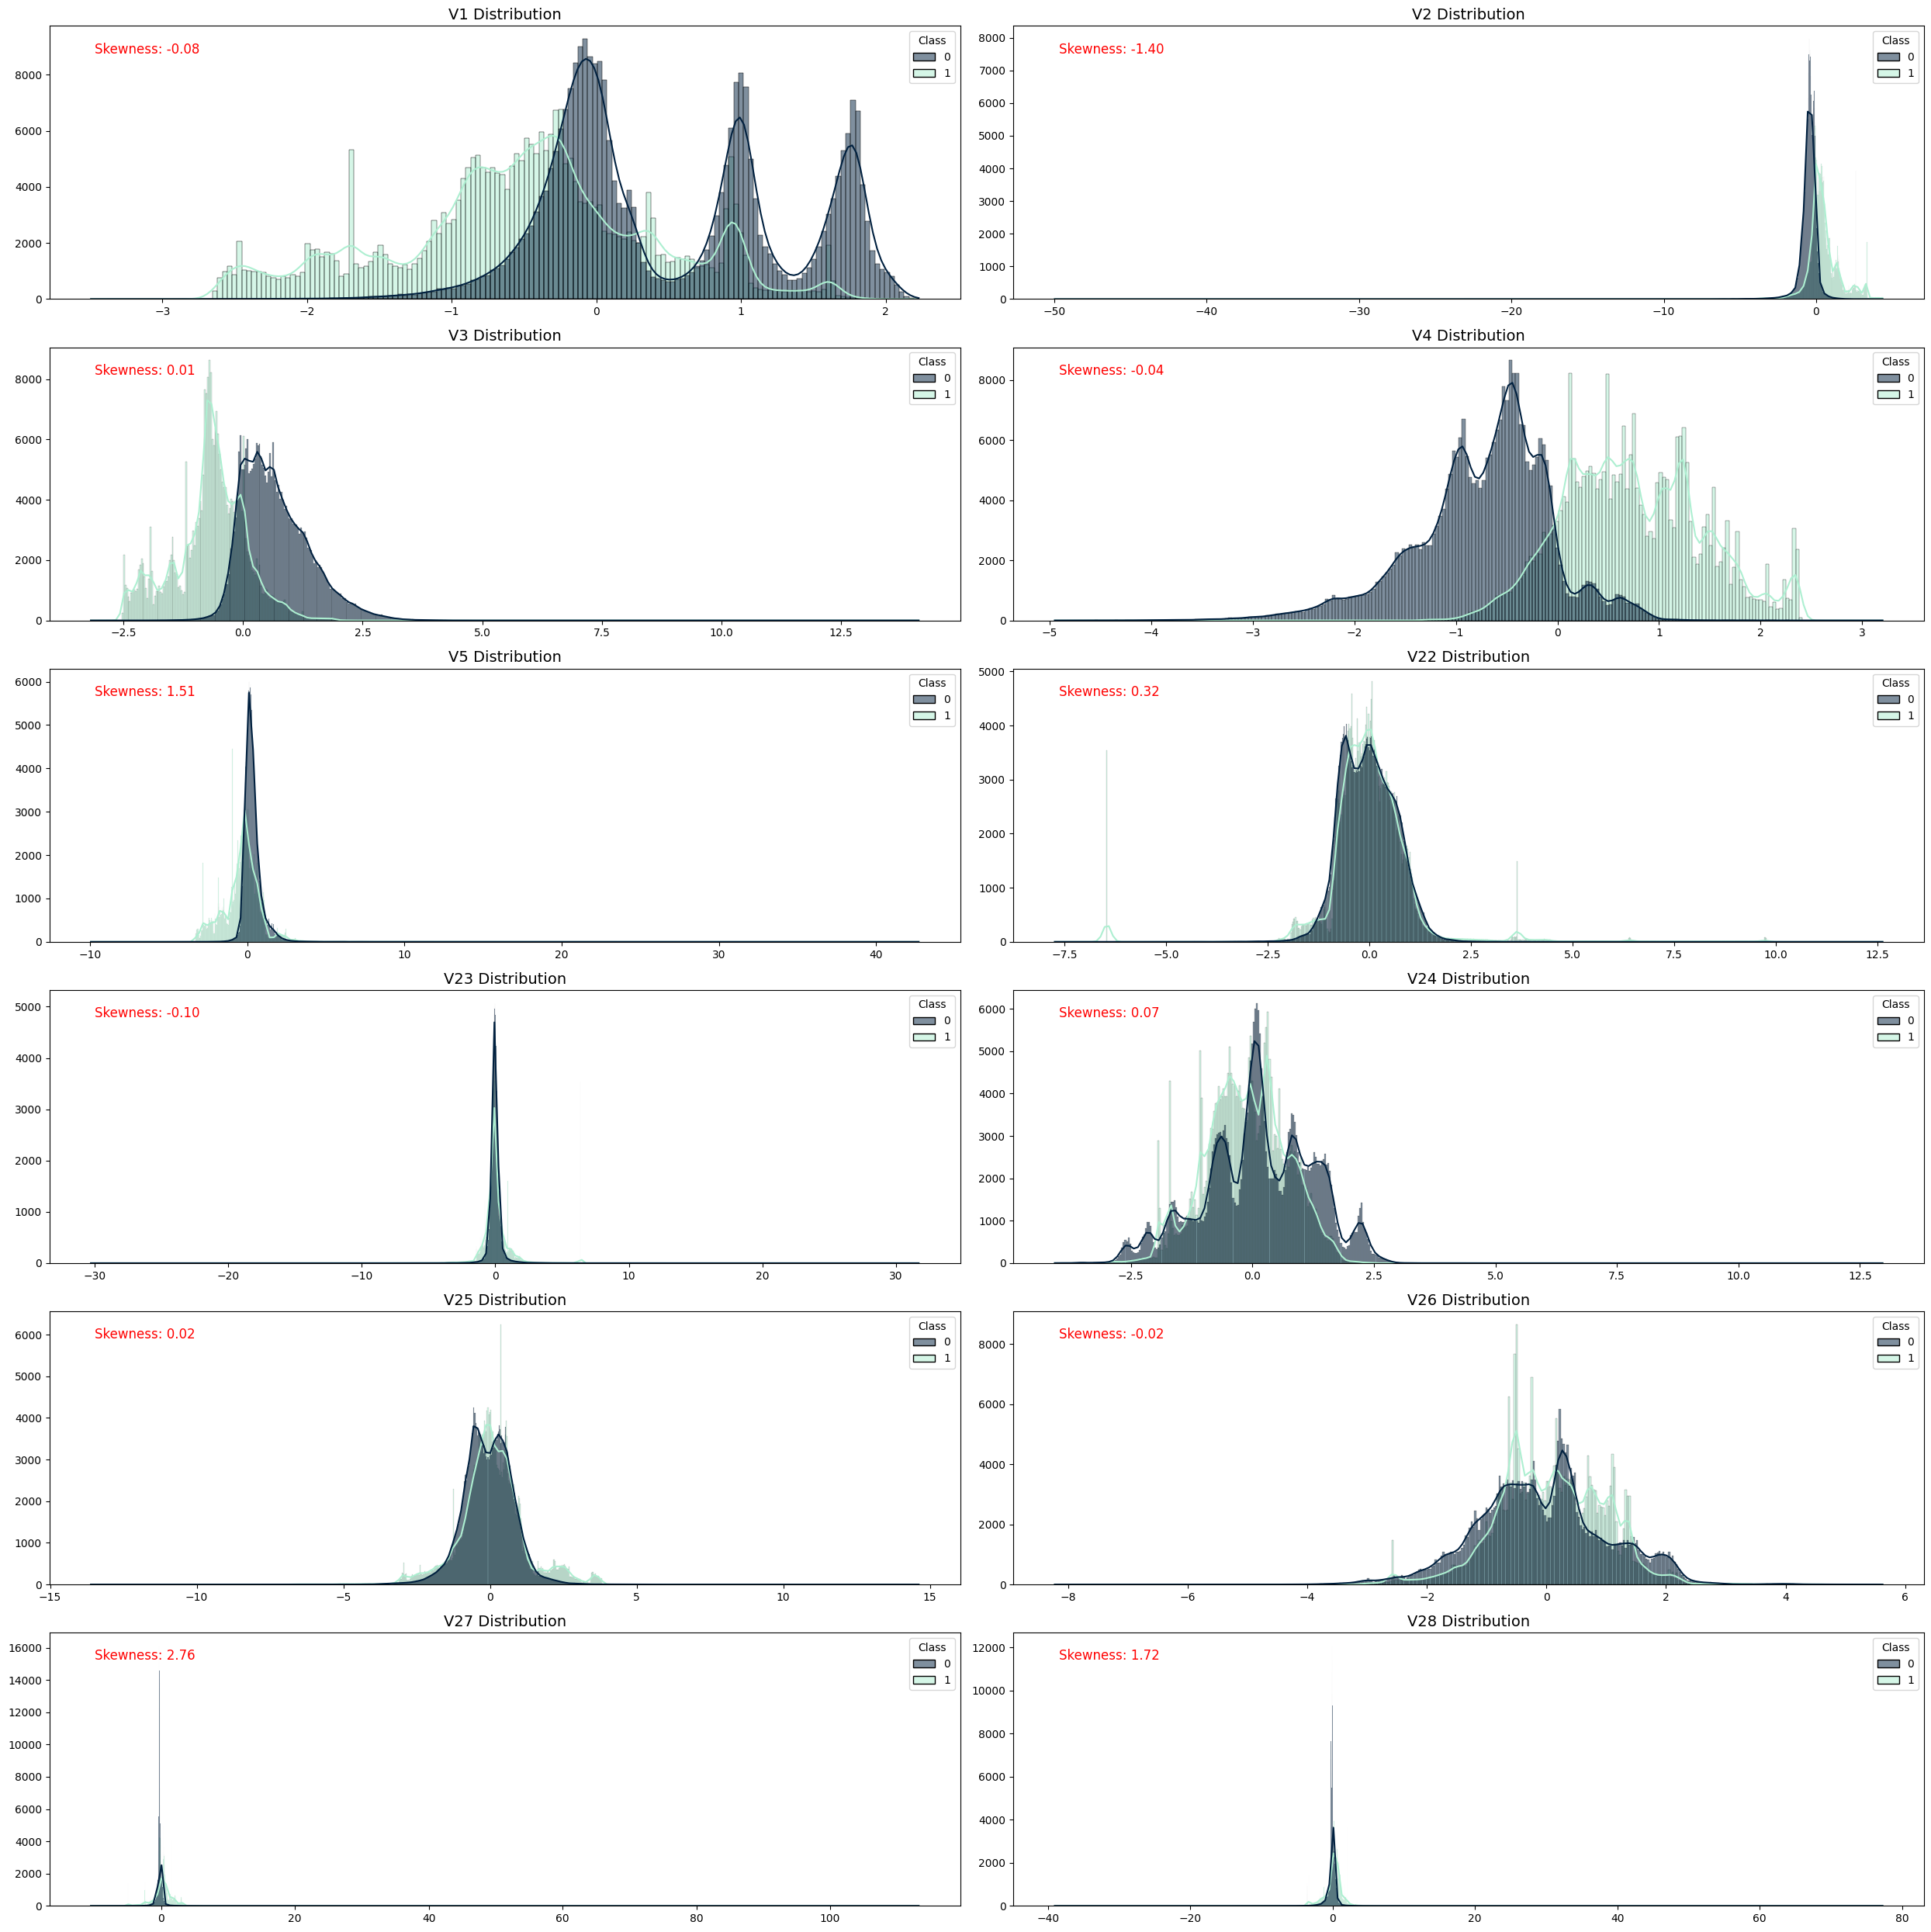

In [10]:
NUM_COLS_F = ['V1','V2','V3','V4','V5','V22','V23','V24','V25','V26','V27','V28']
plot_numerical_distribution_with_hue(data, NUM_COLS_F,'Class')



## Обучение модели

In [5]:
from catboost import CatBoostClassifier

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [13]:
def objective(trial):
    params = {
        'eval_metric': 'AUC',
        'verbose': 0,
        'allow_writing_files': False,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 20, 3000),
        'depth': trial.suggest_int('depth', 4, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 100),
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, 
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

In [14]:
study = optuna.create_study(direction='maximize', 
                            sampler=TPESampler())
study.optimize(objective, n_trials=50)

[I 2025-05-30 14:02:12,917] A new study created in memory with name: no-name-9dffdc0c-a7b0-45f0-a052-ecd11da7258e
[I 2025-05-30 14:02:36,537] Trial 0 finished with value: 0.9999324456776956 and parameters: {'learning_rate': 0.08706619797048937, 'n_estimators': 78, 'depth': 11, 'l2_leaf_reg': 21.620421676827508}. Best is trial 0 with value: 0.9999324456776956.
[I 2025-05-30 14:14:28,050] Trial 1 finished with value: 0.999958472193453 and parameters: {'learning_rate': 0.03752840950582772, 'n_estimators': 808, 'depth': 13, 'l2_leaf_reg': 94.16931041769261}. Best is trial 1 with value: 0.999958472193453.
[I 2025-05-30 14:15:42,711] Trial 2 finished with value: 0.9998518681392097 and parameters: {'learning_rate': 0.010405028125060903, 'n_estimators': 389, 'depth': 10, 'l2_leaf_reg': 21.551145640084215}. Best is trial 1 with value: 0.999958472193453.
[I 2025-05-30 14:17:36,063] Trial 3 finished with value: 0.9999354758069593 and parameters: {'learning_rate': 0.05538062115949371, 'n_estimator

KeyboardInterrupt: 

In [17]:
best_params = study.best_params
X_full, y_full = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_full, y_full, verbose=100)

0:	learn: 0.4869929	total: 705ms	remaining: 18m 1s
100:	learn: 0.0061752	total: 55.6s	remaining: 13m 8s
200:	learn: 0.0032916	total: 1m 43s	remaining: 11m 24s
300:	learn: 0.0032907	total: 2m 19s	remaining: 9m 32s
400:	learn: 0.0032899	total: 2m 55s	remaining: 8m 17s
500:	learn: 0.0032892	total: 3m 32s	remaining: 7m 18s
600:	learn: 0.0032889	total: 4m 8s	remaining: 6m 25s
700:	learn: 0.0032884	total: 4m 44s	remaining: 5m 38s
800:	learn: 0.0032882	total: 5m 20s	remaining: 4m 53s
900:	learn: 0.0032877	total: 5m 55s	remaining: 4m 10s
1000:	learn: 0.0032871	total: 6m 32s	remaining: 3m 29s
1100:	learn: 0.0032868	total: 7m 8s	remaining: 2m 48s
1200:	learn: 0.0032866	total: 7m 44s	remaining: 2m 9s
1300:	learn: 0.0032863	total: 8m 21s	remaining: 1m 30s
1400:	learn: 0.0032860	total: 8m 58s	remaining: 51.5s
1500:	learn: 0.0032856	total: 9m 37s	remaining: 13.1s
1534:	learn: 0.0032853	total: 9m 49s	remaining: 0us


In [7]:
import joblib
final_model = joblib.load('final_model.pkl')

## LIME

In [12]:
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_val.values, feature_names=X_val.columns, discretize_continuous=True, mode='classification')
exp = explainer.explain_instance(X_val.values[0], final_model.predict_proba, num_features=10)

In [13]:
exp.show_in_notebook(show_table=True)

In [14]:
exp.as_list()

[('V14 <= -0.87', 0.3406041430283879),
 ('V4 > 0.70', 0.16965524867086987),
 ('V12 <= -0.83', 0.07321401447129539),
 ('V10 <= -0.59', 0.07308623539595817),
 ('V17 <= -0.62', 0.058182999323290956),
 ('V8 > 0.05', -0.0464860470205779),
 ('V11 > 0.74', 0.04628643360845398),
 ('V3 <= -0.65', 0.04343165002221539),
 ('V16 <= -0.72', 0.04256578091596158),
 ('V7 <= -0.28', 0.03880629242667711)]

In [15]:
exp = explainer.explain_instance(X_train.values[42], final_model.predict_proba, num_features=10)

In [16]:
exp.show_in_notebook()

## SHAP

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_val, y_val)

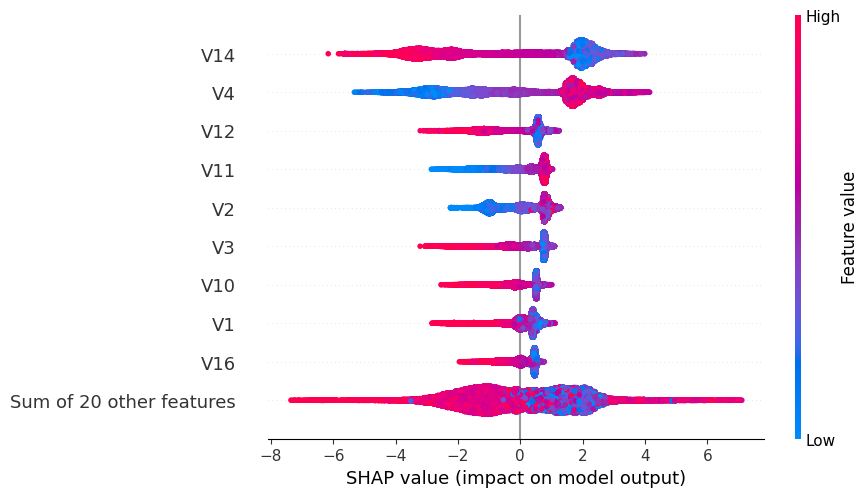

In [9]:
shap.plots.beeswarm(shap_values)

In [11]:
shap.plots.beeswarm(shap_values[..., 0])

ValueError: The beeswarm plot does not support plotting a single instance, please pass an explanation matrix with many instances!